In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7415%2F10564%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240822%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240822T102859Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1e322fbc1c3a7e22c8828c3e3fe52c8a897f1502215fa6bddae0dde53483d2bbd8b4916fce22e158a7399e882d2bc70c3b6ce1d11da82b44270bcbb793285401d5c76642ce864da5a5a90c9198a7840bc760c215d2502d8f13b73f0d87a5b542942270de8feb914ca59e978bda38a2a6e98b3358e4447a403fcc4afdd93c076cf385febdf45bf3efc97716d0b8de7e9f752fa5fd8326a9eb0e53aaef123cd8c86e3c4baac3987164da6e0771b0bb0c6ad35be9e5e1f0c0f6dda4a1efcc2c4a0e27e5bc986baed7e56f9fb1393cf67ce632c5fd362193f1edd809a164fa141e4fc8edcbe30d05310f0addd22a46ffc58f8d02a394d2e6733a2bc1951a9e694085'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 3326820824 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


*Step 1: Import Modules*

In [ ]:
  import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
# Use imageio instead of scipy.misc for image reading
import imageio.v3 as iio
# Use skimage instead of scipy.misc for image resizing
from skimage.transform import resize
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Import ImageDataGenerator from the correct module for TensorFlow 2.x
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

*Step 2: Explore Data*

In [ ]:
imagePatches = glob('/kaggle/input/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x2851_y1451_class0.png
/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x801_y2251_class0.png
/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x301_y601_class0.png
/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x2101_y101_class0.png
/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x601_y2151_class0.png
/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x2601_y1651_class0.png
/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x701_y2051_class0.png
/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x451_y951_class0.png
/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x601_y2101_class0.png
/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x2901_y1401_class0.png


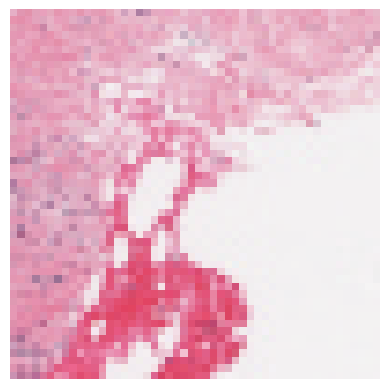

In [ ]:
image_name = "/kaggle/input/IDC_regular_ps50_idx5/9135/1/9135_idx5_x1701_y1851_class1.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

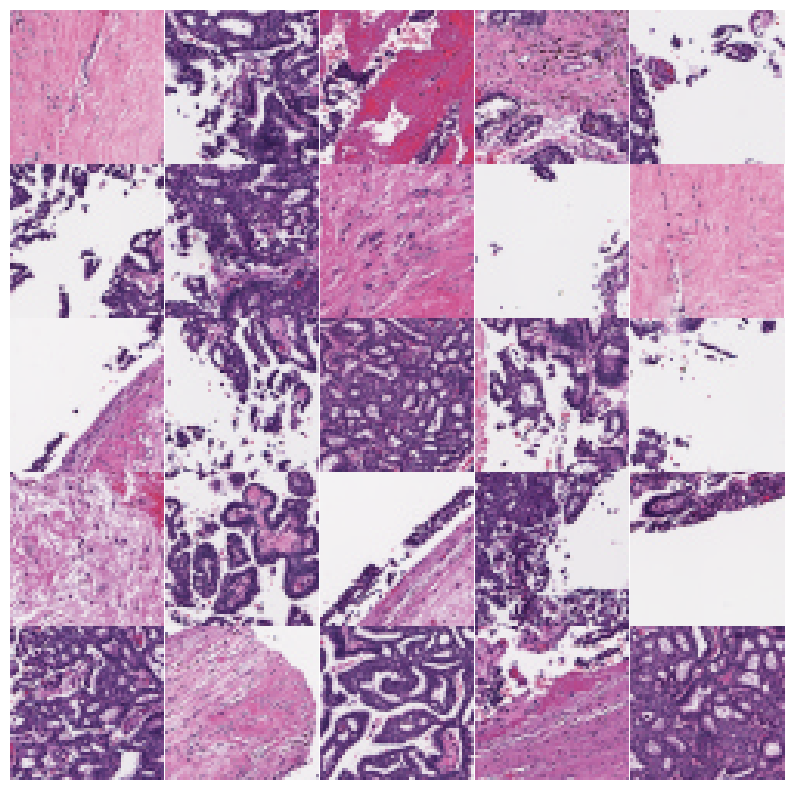

In [ ]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50))
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

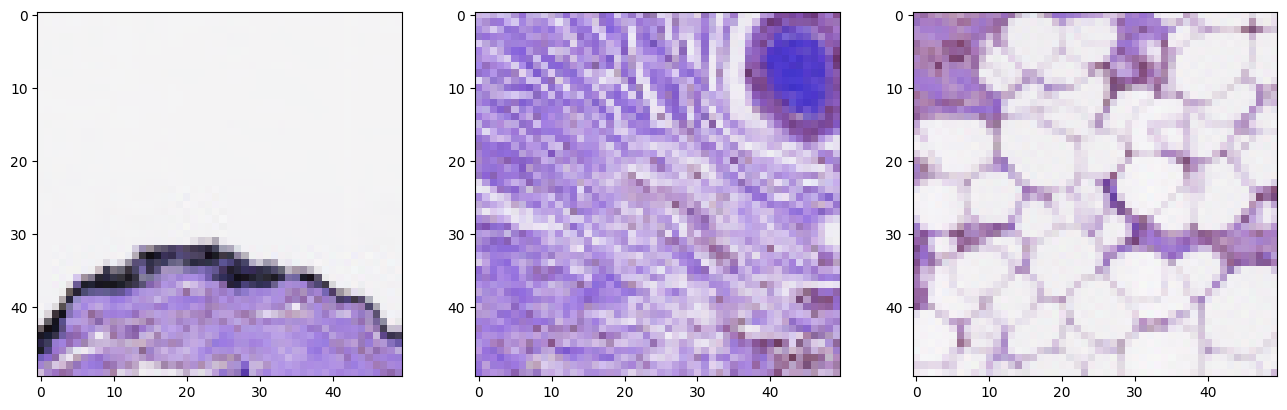

In [ ]:
def randomImages(a):
    r = random.sample(a, 4)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]));
randomImages(imagePatches)

*Step 3: Preprocess Data*

In [ ]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x2851_y1451_class0.png', '/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x801_y2251_class0.png', '/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x301_y601_class0.png', '/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x2101_y101_class0.png', '/kaggle/input/IDC_regular_ps50_idx5/10302/0/10302_idx5_x601_y2151_class0.png'] 

IDC(+)

 ['/kaggle/input/IDC_regular_ps50_idx5/10302/1/10302_idx5_x1001_y901_class1.png', '/kaggle/input/IDC_regular_ps50_idx5/10302/1/10302_idx5_x1601_y1101_class1.png', '/kaggle/input/IDC_regular_ps50_idx5/10302/1/10302_idx5_x1501_y1551_class1.png', '/kaggle/input/IDC_regular_ps50_idx5/10302/1/10302_idx5_x1251_y951_class1.png', '/kaggle/input/IDC_regular_ps50_idx5/10302/1/10302_idx5_x1201_y1201_class1.png']


In [ ]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays:
        x is an array of resized images
        y is an array of labels
    """
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [ ]:
X,Y = proc_images(0,90000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1]

In [ ]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 90000
Number of IDC(-) Images: 61191
Number of IDC(+) Images: 28809
Percentage of positive images: 32.01%
Image shape (Width, Height, Channels): (50, 50, 3)


In [ ]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[180, 141, 198], [159, 110, 173], [173, 137,...       0
1  [[[198, 162, 194], [199, 165, 200], [175, 132,...       0
2  [[[132, 69, 190], [105, 54, 189], [109, 54, 18...       0
3  [[[150, 90, 193], [173, 130, 179], [172, 128, ...       0
4  [[[237, 235, 237], [237, 235, 237], [237, 235,...       0
5  [[[116, 58, 95], [174, 140, 171], [122, 75, 10...       0
6  [[[211, 192, 204], [160, 126, 161], [121, 60, ...       0
7  [[[174, 118, 209], [163, 102, 200], [190, 145,...       0
8  [[[239, 237, 239], [239, 237, 239], [239, 237,...       0
9  [[[195, 161, 223], [185, 147, 223], [168, 118,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


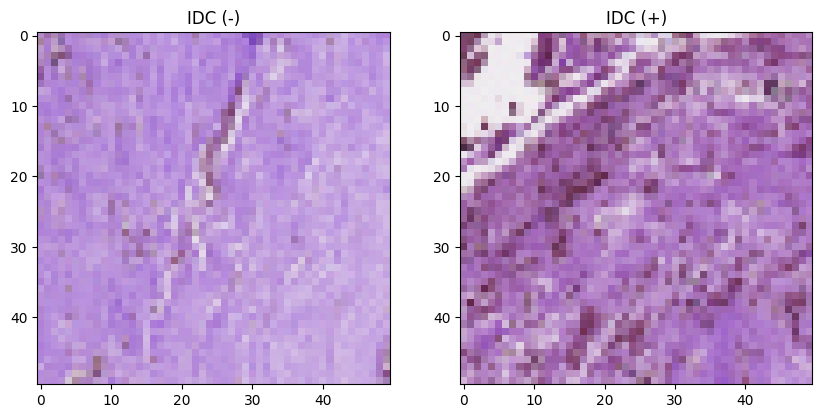

In [ ]:
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[0])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[0])
plotOne(imgs0, imgs1)

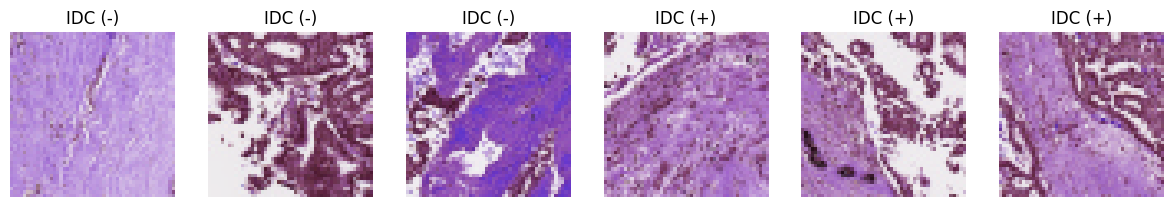

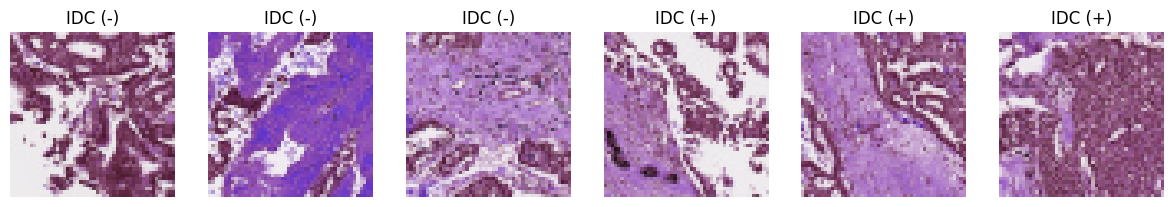

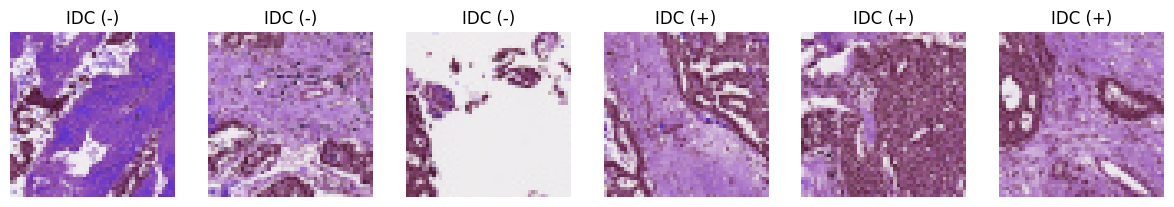

In [ ]:
def plotTwo(a,b):
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[0+row+col])
            plt.axis('off')
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1)

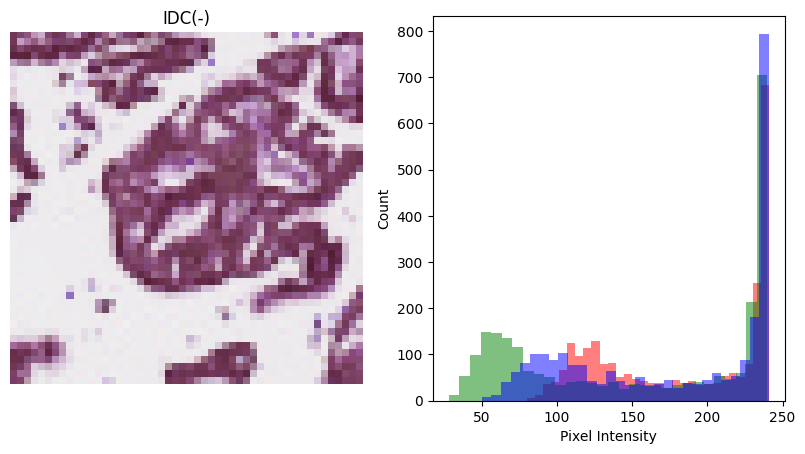

In [ ]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[100])

In [ ]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:300000]
Y_train = Y_train[0:300000]
X_test = X_test[0:300000]
Y_test = Y_test[0:300000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (72000, 50, 50, 3)
Testing Data Shape: (18000, 50, 50, 3)


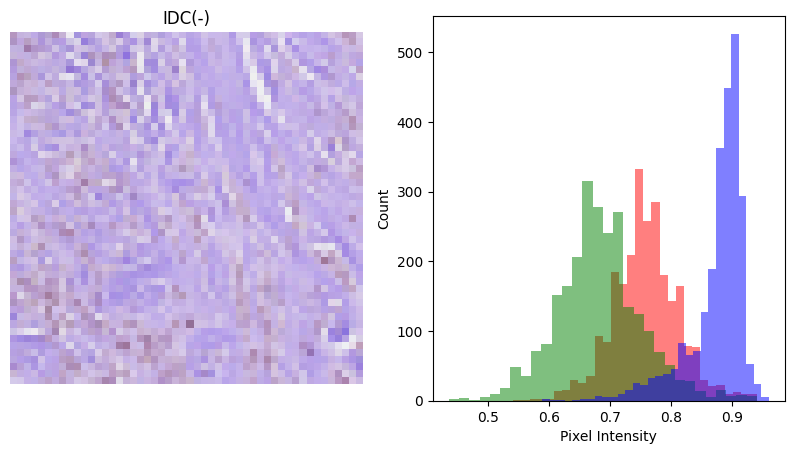

In [ ]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    # Assuming Y is defined somewhere and contains labels
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

# Assuming X_train is defined as in your provided code
plotHistogram(X_train[100])

In [ ]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

{0: 'IDC(-)', 1: 'IDC(+)'}


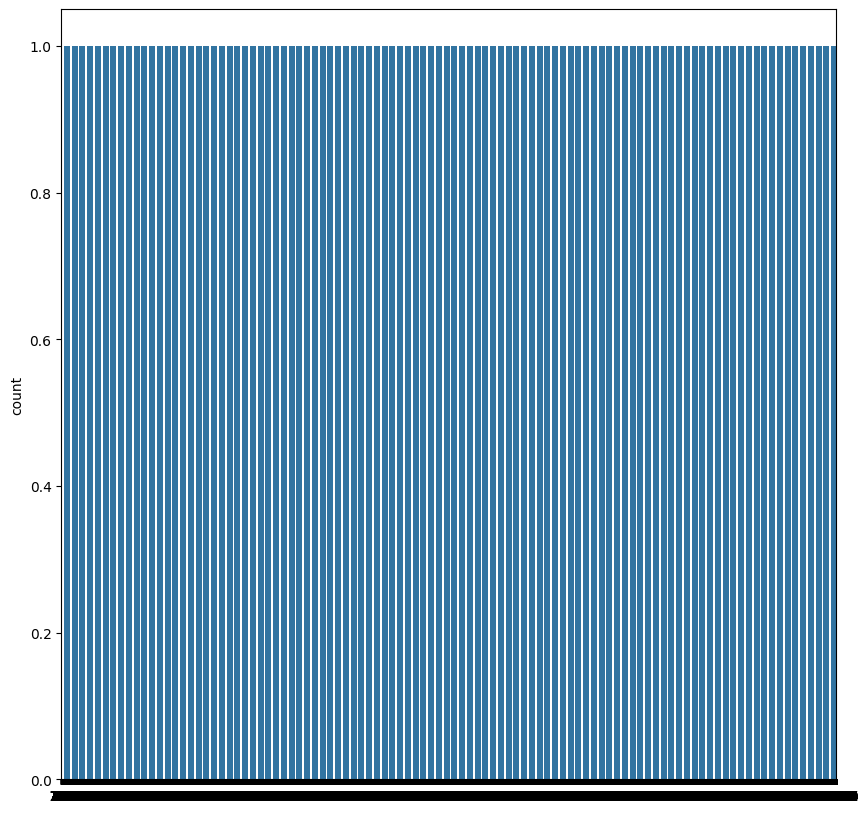

In [ ]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

{0: 'IDC(-)', 1: 'IDC(+)'}


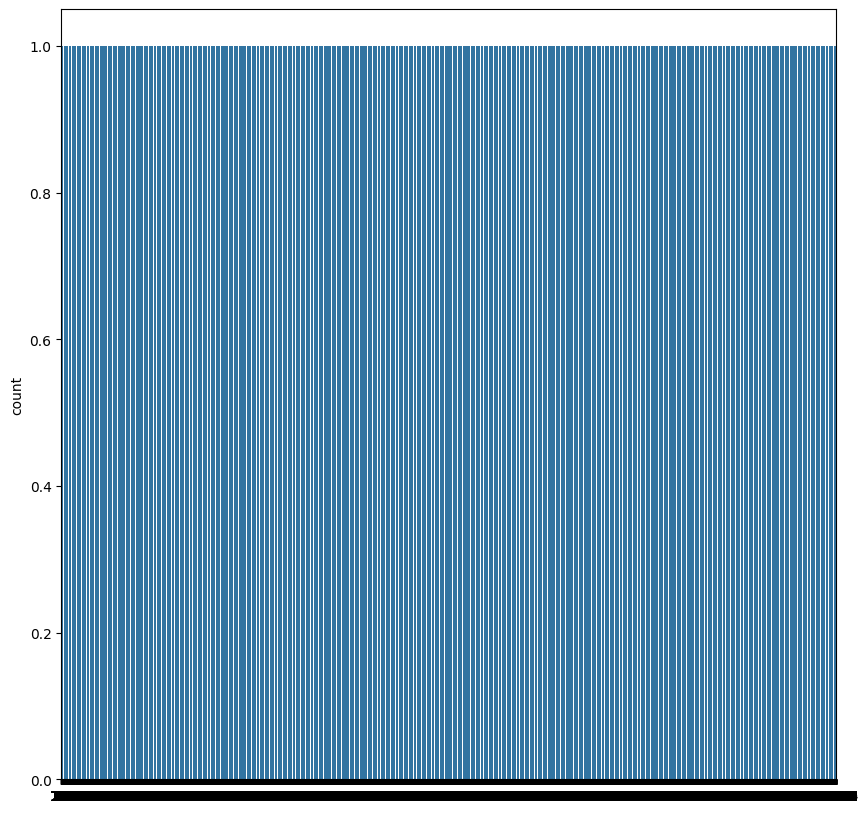

In [ ]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
#print("X_train Shape: ",X_train.shape)
#print("X_test Shape: ",X_test.shape)
#print("X_trainFlat Shape: ",X_trainFlat.shape)
#print("X_testFlat Shape: ",X_testFlat.shape)

!pip install imblearn --upgrade
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(sampling_strategy='auto')
X_trainRos, Y_trainRos = ros.fit_resample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_resample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

*Step 4: Define Helper Functions for the Classification Task*

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(Y_train), y = Y_train) # Change variable name to class_weights
print("Old Class Weights: ",class_weights)
class_weights2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(Y_trainRos), y = Y_trainRos)
print("New Class Weights: ",class_weights2)

Old Class Weights:  [0.73488885 1.5643332 ]
New Class Weights:  [1. 1.]


In [ ]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

*Step 5: Evaluate Classification Models*

In [ ]:
def runKerasCNNAugment(a,b,c,d,e,f=None): # add default value to f
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = 8
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

    # Convert class_weights2 to a dictionary
    if f is not None:
        class_weight_dict = {i: weight for i, weight in enumerate(f)}
    else:
        class_weight_dict = None

    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=class_weight_dict,
                        validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis=1)
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show() # Moved outside of the function
    plot_learning_curve(history)
    plt.show() # Moved outside of the function
    confusion_mtx = confusion_matrix(Y_true, Y) # Assuming Y is available in the scope

In [ ]:
#runKerasCNNAugment(X_train, Y_trainHot, X_test, Y_testHot,2,class_weight)